# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [126]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("v.matveeva") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

Создаем отдельный класс для объекта выборки

In [5]:
FALSE = 0
TRUE = 1
NOIZE = 0

class Object:
    """
    Vector with properties
    """
    # vector
    def __init__(self, vect = [], index = 0):
        self.vect = vect
        self.index = index
    processed = FALSE
    reachability_distance = np.inf
    core_distance = np.inf
    clusterID = NOIZE
    core_object = None
    
    
    def distance(self, obj):
        return np.sqrt(np.sum((self.vect - obj.vect)**2))
    
    def __lt__(self, obj):
        return self.distance(self.core_object) < obj.distance(obj.core_object)
    

In [199]:
import heapdict
TRUE = 1
FALSE = 0
NOISE = 0
class Clustering:
    """
    Implement clustering algorithm according 
    """

    def __init__(self, minPts = 2, eps = 2, treshold = 1.4):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.minPts = minPts
        self.eps = eps
        self.treshold = treshold
        self.OrderedList = []
        self.OrderSeeds = heapdict.heapdict()
        return
        
    #вычисление множества соседей
    def neighborhood(self, cur_obj, obj_list):
        neighbors = []
        for obj in obj_list:
            if obj != cur_obj and cur_obj.distance(obj) <= self.eps:
                obj.core_object = cur_obj
                neighbors.append(obj)
        return neighbors
    
    #вычисление core-distance объекта
    def setCoreDistance(self, cur_obj, neighbors):
        #если cur_obj это core-object
        if len(neighbors) >= self.minPts:
            # minPts порядковая статистика
            minPtsObj = np.partition(neighbors, self.minPts - 1)[self.minPts - 1]
            cur_obj.core_distance = cur_obj.distance(minPtsObj)
            
    def update(self, neighbors, CenterObject):
        c_dist = CenterObject.core_distance
        for obj in neighbors:
            if not obj.processed:
                new_r_dist = max(c_dist, CenterObject.distance(obj))
                if obj.reachability_distance == np.inf:
                    obj.reachability_distance = new_r_dist
                    self.OrderSeeds[obj] = new_r_dist
                else:
                    if new_r_dist < obj.reachability_distance:
                        obj.reachability_distance = new_r_dist
                        self.OrderSeeds[obj] = new_r_dist
    
    def expandClusterOrder(self, obj):
        neighbors = self.neighborhood(obj, self.setOfObjects)
        obj.processed = TRUE
        obj.reachability_distance = np.inf
        self.setCoreDistance(obj, neighbors)
        self.OrderedList.append(obj)
        if obj.core_distance != np.inf:
            self.update(neighbors, obj)
            while self.OrderSeeds.items() != []:
                currentObject = self.OrderSeeds.popitem()[0]
                neighbors = self.neighborhood(currentObject, self.setOfObjects)
                currentObject.processed = TRUE
                self.setCoreDistance(currentObject, neighbors)
                self.OrderedList.append(currentObject)
                if currentObject.core_distance != np.inf:
                    self.update(neighbors, currentObject)

    def ExtractDBSCANClustering(self):
        ClusterID = NOISE
        for obj in self.OrderedList:
            if obj.reachability_distance > self.treshold:
                if obj.core_distance <= self.treshold:
                    ClusterID += 1
                    obj.clusterID = ClusterID
                else:
                    obj.clusterID = NOISE
            else:     # Object.reachability_distance <= treshold
                obj.clusterID = ClusterID
        self.maxCluster = ClusterID

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        # из исходной матрицы составляем setOfObjects
        self.setOfObjects = []
        for i, raw in enumerate(x):
            obj = Object(raw, i)
            self.setOfObjects.append(obj)
            
        for obj in self.setOfObjects:
            if not obj.processed:
                self.expandClusterOrder(obj)
        self.ExtractDBSCANClustering()
        print 'minPts = ', self.minPts
        print 'eps = ', self.eps
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        listOfClusters = np.array([i.clusterID for i in self.OrderedList])
        return listOfClusters
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

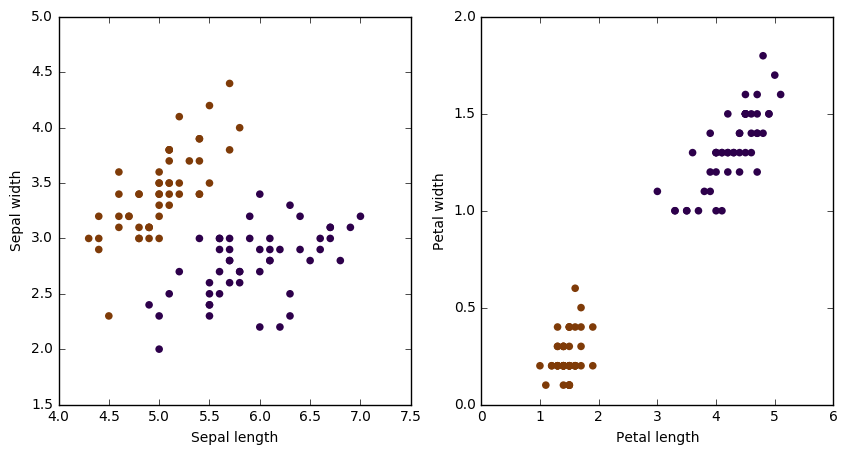

In [142]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [10]:
pred_iris = Clustering().fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

Критерий Silhouette:

In [46]:
from scipy.spatial.distance import cdist

In [189]:
def intra_cluster_distance(distances_row, y, i):
    """
    Среднее расстояние внутри кластера для объекта x_i
    """
    mask = y == y[i]
    mask[i] = False
    if not np.any(mask):
        return 0
    a = np.mean(distances_row[mask])
    return a


def nearest_cluster_distance(distances_row, y, i):
    """
    Среднее расстояние внe кластера для объекта x_i
    """
    label = y[i]
    lst = [np.mean(distances_row[y == cur_label]) for cur_label in set(y) if not cur_label == label]
    if lst == []:
        return 0
    else:
        return np.min(lst)

def quality(x, y):
    distances = cdist(x, x)
    n = y.shape[0]
    A = np.array([intra_cluster_distance(distances[i], y, i) for i in range(n)])
    B = np.array([nearest_cluster_distance(distances[i], y, i) for i in range(n)])
    silhouette = np.mean((B - A) / np.maximum(A, B))
    return silhouette

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Также для анализа, свойственного алгоритмам dbscan и optics, постпроим reachability plot для выбора подходящих параметров.

In [267]:
cls = Clustering(minPts=10, eps=0.2, treshold = 0.12)
lst = cls.fit(x).OrderedList

minPts =  10
eps =  0.2


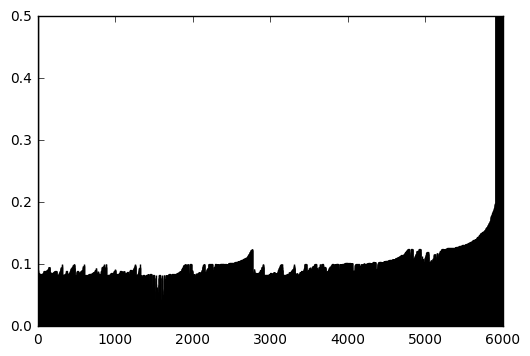

In [261]:
xaxis = [i for i in xrange(len(lst))]
yaxis = [i.reachability_distance if i.reachability_distance != np.inf else 0.5 for i in lst]
pl.bar(xaxis, yaxis)
pl.show()

In [268]:
cls.maxCluster

5

In [274]:
y = np.array([i.clusterID for i in cls.OrderedList])
len(y[y == 5])

8

Проверка критерия Silhouette:

0
minPts =  1
eps =  0.1
clusterCount =  5
-0.329131860278 

1
minPts =  1
eps =  0.2
clusterCount =  18
-0.442836673466 

2
minPts =  1
eps =  0.3
clusterCount =  11
-0.273989027062 

3
minPts =  1
eps =  0.4
clusterCount =  1
-0.00778384659465 

4
minPts =  2
eps =  0.1
clusterCount =  1
-0.108275211015 

5
minPts =  2
eps =  0.2
clusterCount =  6
-0.314609244374 

6
minPts =  2
eps =  0.3
clusterCount =  9
-0.264859438019 

7
minPts =  2
eps =  0.4
clusterCount =  1
-0.00778384659465 

8
minPts =  3
eps =  0.1
clusterCount =  0
-1.0 

9
minPts =  3
eps =  0.2
clusterCount =  2
-0.164518435157 

10
minPts =  3
eps =  0.3
clusterCount =  6
-0.207875586505 

11
minPts =  3
eps =  0.4
clusterCount =  1
-0.00778384659465 

12
minPts =  4
eps =  0.1
clusterCount =  0
-1.0 

13
minPts =  4
eps =  0.2
clusterCount =  1
-0.0244534207074 

14
minPts =  4
eps =  0.3
clusterCount =  3
-0.140055861869 

15
minPts =  4
eps =  0.4
clusterCount =  1
-0.0258092007954 

16
minPts =  5
eps =  0.1
clus

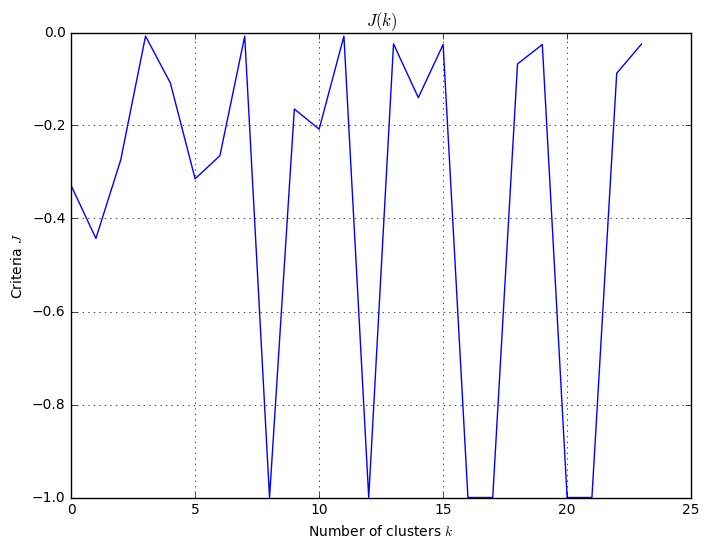

In [200]:
ks = range(1, 7)
eps = np.linspace(0.1, 0.4, 4)
criteria = np.zeros(len(ks) * len(eps))
xlen = range(len(ks) * len(eps))
for i, k in enumerate(ks):
    for j, e in enumerate(eps):
        print i * len(eps) + j
        cls = Clustering(minPts = k, eps = e, treshold = 0.7 * e)
        y = cls.fit_predict(x[-100:])
        print 'clusterCount = ', cls.maxCluster
        criteria[i * len(eps) + j] = quality(x[-100:], y)
        print criteria[i * len(eps) + j], '\n'
    
pl.figure(figsize=(8, 6))
pl.plot(xlen, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

При eps = 0.2, minPts = 10 и treshold = 0.12 (построен reachability plot и проведен выбор значений на его анализе) получилось 5 кластеров + 1 класс - с шумом.

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [18]:
k = 5
cls = Clustering(minPts=10, eps=0.2, treshold = 0.12)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

In [275]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...


MemoryError: 

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

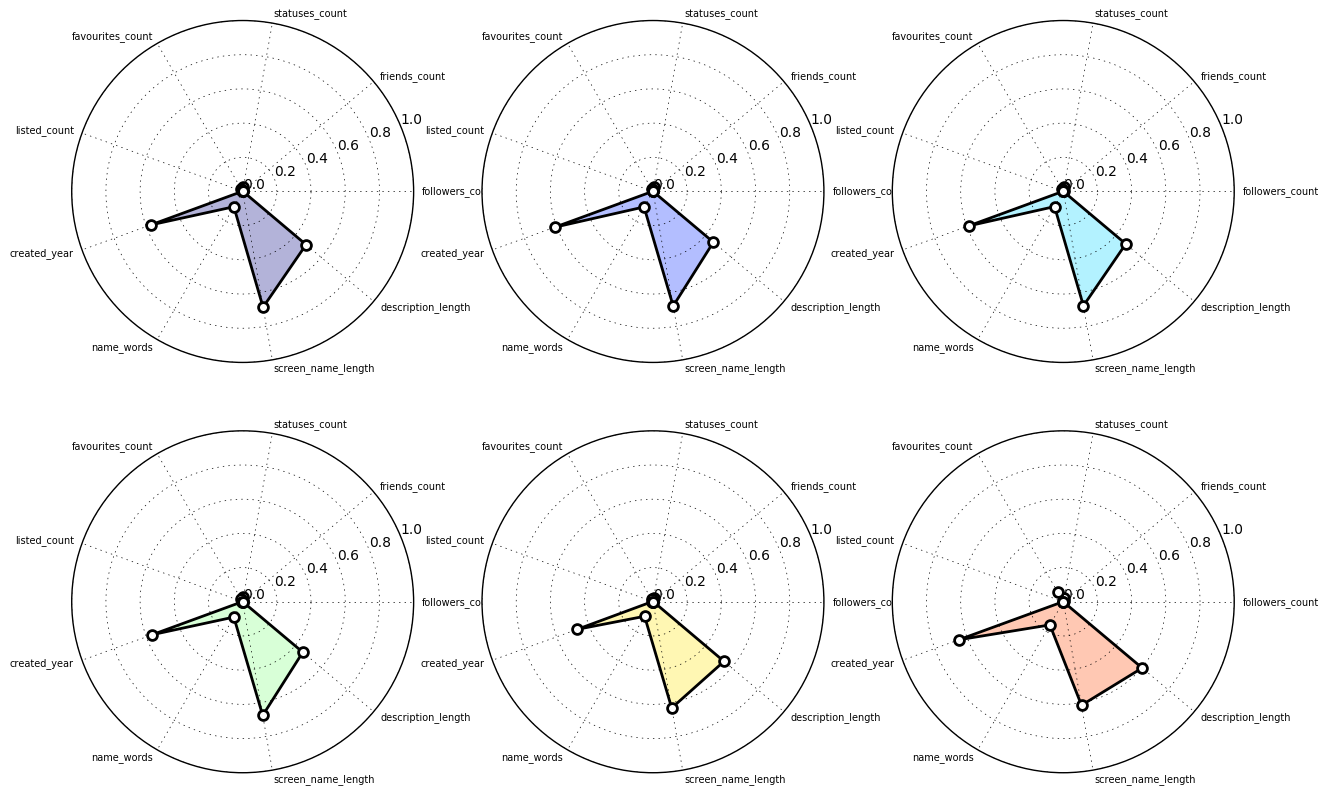

In [276]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Кластеры в принципе похожи, незначительно отличаются друг от друга description_length и name_words. Желтый кластер заметно отличается от остальных created_year.

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.